In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt

In [60]:
leaf_size = [20,30,40]
n_neighbors = [3,5,7]
# p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors,p=[2])
knn_r = KNeighborsRegressor()
model =  GridSearchCV(knn_r, hyperparameters)

### Time feature data

In [3]:
model = KNeighborsRegressor(
 algorithm= 'auto',
 leaf_size= 30,
 metric= 'minkowski',
 metric_params= None,
 n_jobs= 15,
 n_neighbors= 5,
 p= 2,
 weights= 'uniform')

In [4]:
def return_data(fold,month,with_scaling):
    train_input = pd.read_csv('../data/time_feature'+'/fold'+str(fold)+'/train_data_'+month+'.csv.gz')
    test_input = pd.read_csv('../data/time_feature'+'/fold'+str(fold)+'/test_data_'+month+'.csv.gz')
    test_output = np.array(test_input['PM25_Concentration'])
    train_output = np.array(train_input['PM25_Concentration'])
    train_input= train_input.drop(['station_id','PM25_Concentration','time','filled'],axis=1)
    try:
        test_input= test_input.drop(['PM25_Concentration','station_id','time','filled'],axis=1)
    except:
        test_input= test_input.drop(['station_id','time','filled'],axis=1)
#     test_output= test_output.drop(['time'],axis=1)
    if with_scaling:
        scaler = MinMaxScaler().fit(train_input)
        train_input = scaler.transform(train_input)
        test_input = scaler.transform(test_input)
    return train_input,train_output,test_input,test_output

def run_model(model,train_input,train_output,test_input,test_output,ret_output):
    model.fit(np.array(train_input), train_output)
    test_pred = model.predict(np.array(test_input))
    err = mean_squared_error(test_pred, test_output, squared=False)
    if ret_output:
        return err,test_pred
    else:
        return err

### With scaling

In [5]:
for fold in [0,1,2]:
    train_input,train_output,test_input,test_output = return_data(fold=fold,month='mar',with_scaling=True)
    print("Fold: ",fold)
    print("Data received")
    init = time()
    rmse,test_pred = run_model(model,train_input,train_output,test_input,test_output,True)
    print("RMSE: ",rmse)
    print("Time taken: ",time()-init)
    test_input = pd.read_csv('../data/time_feature'+'/fold'+str(fold)+'/test_data_'+'mar'+'.csv.gz')
    test_input['prediction']= test_pred
    test_input.to_csv('../data/'+'results/results_mar'+'/fold'+str(fold)+'/KNN_scaled.csv.gz')

Fold:  0
Data received
RMSE:  38.091937561028885
Time taken:  2.9904239177703857
Fold:  1
Data received
RMSE:  38.85355585774534
Time taken:  2.989856004714966
Fold:  2
Data received
RMSE:  37.02358293230134
Time taken:  3.007683515548706


### Without scaling

In [5]:
for fold in [0,1,2]:
    train_input,train_output,test_input,test_output = return_data(fold=fold,month='mar',with_scaling=False)
    print("Fold: ",fold)
    print("Data received")
    init = time()
    rmse,test_pred = run_model(model,train_input,train_output,test_input,test_output,True)
    print("RMSE: ",rmse)
    print("Time taken: ",time()-init)
    test_input = pd.read_csv('../data/processed/'+'/fold_'+str(fold)+'_test_'+'mar'+'.csv.gz')
    test_input['prediction']= test_pred
    test_input.to_csv('../data/'+'results/results_mar'+'/fold'+str(fold)+'/KNN_nonscaled.csv.gz')

Fold:  0
Data received
RMSE:  52.446787418382755
Time taken:  418.717502117157
Fold:  1
Data received
RMSE:  56.71980590215274
Time taken:  425.8672125339508
Fold:  2
Data received
RMSE:  53.16574860585825
Time taken:  428.7263777256012


### Don't look ahead

In [12]:
fold = 2
train_input,train_output,test_input,test_output = return_data(fold=fold,type='time_feature')
print("Fold: ",fold)
print("Data received")
# model = KNeighborsRegressor(n_neighbors=3)
init = time()
print("RMSE: ",run_model(model,train_input,train_output,test_input,test_output,False))
print("Time taken: ",time()-init)
# model.get_params()

Fold:  2
Data received
RMSE:  20.854444282158408
Time taken:  3.1349098682403564


### Auto-regressive data


In [13]:
model = KNeighborsRegressor(
  algorithm= 'auto',
  leaf_size= 30,
  metric= 'minkowski',
  metric_params= None,
  n_jobs= None,
  n_neighbors= 5,
  p= 2,
  weights=  'uniform'
)

In [51]:
fold = 0
train_input,train_output,test_input,test_output = return_data(fold=fold,type='auto_regressive')
print("Fold: ",fold)
print("Data received")
# model = KNeighborsRegressor(n_neighbors=3)
init = time()
rmse, test_pred = run_model(model,train_input,train_output,test_input,test_output,True)
print("RMSE: ",rmse)
print("Time taken: ",time()-init)
# model.get_params()

Fold:  0
Data received
RMSE:  40.53266467700296
Time taken:  2.93772029876709


In [52]:
test_input = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_data_month.csv.gz')
test_output = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_output_month.csv.gz')
test_output= test_output.drop(['time'],axis=1)
stationids = test_input.station_id.unique()
for station in stationids:
    rows = test_input[test_input['station_id']==station].index
    err = mean_squared_error(np.array(test_pred)[rows], np.array(test_output)[rows], squared=False)
    print(station,err)

1003 22.019695770822747
1006 16.94071944637388
1012 38.396163242678526
1014 18.30274549115837
1017 54.73280998994597
1023 63.93657413583068
1028 22.97013637583794
1029 40.57051843314697
1031 43.334878296856935
1033 35.6878846282579
1035 55.51628791269157


In [38]:
fold = 1
train_input,train_output,test_input,test_output = return_data(fold=fold,type='auto_regressive')
print("Fold: ",fold)
print("Data received")
# model = KNeighborsRegressor(n_neighbors=3)
init = time()
rmse, test_pred = run_model(model,train_input,train_output,test_input,test_output,True)
print("RMSE: ",rmse)
print("Time taken: ",time()-init)
# model.get_params()

Fold:  1
Data received
RMSE:  144.95746424823093
Time taken:  2.7877166271209717


In [39]:
test_input = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_data_month.csv.gz')
test_output = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_output_month.csv.gz')
test_output= test_output.drop(['time'],axis=1)
stationids = test_input.station_id.unique()
for station in stationids:
    rows = test_input[test_input['station_id']==station].index
    err = mean_squared_error(np.array(test_pred)[rows], np.array(test_output)[rows], squared=False)
    print(station,err)

1002 21.088510061485298
1005 32.585691433053654
1007 17.41470200572073
1010 18.848403136495726
1018 31.669943964466714
1022 19.98932459385624
1024 63.33232975713391
1026 26.615981543357414
1030 66.52885383682296
1036 444.31243108424167


Text(0, 0.5, 'AQ Value')

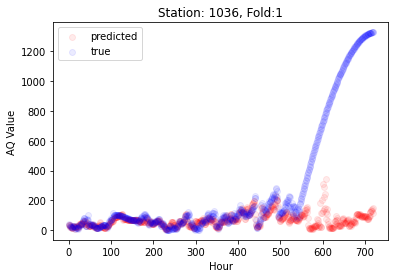

In [40]:
test_input = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_data_month.csv.gz')
test_output = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_output_month.csv.gz')
test_output= test_output.drop(['time'],axis=1)
rows = test_input[test_input['station_id']==1036].index
a = plt.scatter(range(len(np.array(test_pred)[rows])),np.array(test_pred)[rows],c='r',alpha=0.08)
b = plt.scatter(range(len(np.array(test_output)[rows])),np.array(test_output)[rows],c='b',alpha=0.08)
plt.legend((a,b),('predicted','true'))
plt.title("Station: 1036, Fold:1")
plt.xlabel("Hour")
plt.ylabel("AQ Value")

In [34]:
fold = 2
train_input,train_output,test_input,test_output = return_data(fold=fold,type='auto_regressive')
print("Fold: ",fold)
print("Data received")
# model = KNeighborsRegressor(n_neighbors=3)
init = time()
rmse, test_pred = run_model(model,train_input,train_output,test_input,test_output,True)
print("RMSE: ",rmse)
print("Time taken: ",time()-init)
# model.get_params()

Fold:  2
Data received
RMSE:  97.40974920560699
Time taken:  2.7490932941436768


In [35]:
test_input = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_data_month.csv.gz')
test_output = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_output_month.csv.gz')
test_output= test_output.drop(['time'],axis=1)
stationids = test_input.station_id.unique()
for station in stationids:
    rows = test_input[test_input['station_id']==station].index
    err = mean_squared_error(np.array(test_pred)[rows], np.array(test_output)[rows], squared=False)
    print(station,err)

1001 23.946698080606843
1004 17.116695874227535
1008 19.45083333445652
1011 27.2219404874336
1016 15.104077315919811
1019 49.08112709897209
1025 25.423187131774142
1027 78.08556652450989
1032 44.281791649700644
1034 285.58560259771974


Text(0, 0.5, 'AQ Value')

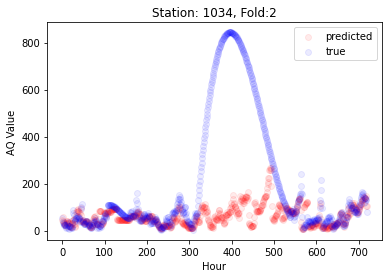

In [37]:
test_input = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_data_month.csv.gz')
test_output = pd.read_csv('../data/'+'auto_regressive'+'/fold'+str(fold)+'/test_output_month.csv.gz')
test_output= test_output.drop(['time'],axis=1)
rows = test_input[test_input['station_id']==1034].index
a = plt.scatter(range(len(np.array(test_pred)[rows])),np.array(test_pred)[rows],c='r',alpha=0.08)
b = plt.scatter(range(len(np.array(test_output)[rows])),np.array(test_output)[rows],c='b',alpha=0.08)
plt.legend((a,b),('predicted','true'))
plt.title("Station: 1034, Fold:2")
plt.xlabel("Hour")
plt.ylabel("AQ Value")